In [28]:
import mediapipe as mp
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import roboflow
import json
import os

loading Roboflow workspace...
loading Roboflow project...


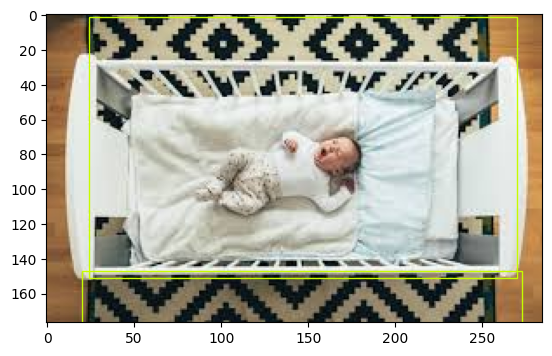

{'predictions': [{'x': 147.0,
   'y': 76.0,
   'width': 246.0,
   'height': 150.0,
   'confidence': 0.9375565052032471,
   'class': 'Crib',
   'class_id': 0,
   'detection_id': 'efc3ccd4-2b43-4049-8e32-eeb3ea5976e0',
   'image_path': 'datasets_testing/4.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 146.5,
   'y': 162.0,
   'width': 253.0,
   'height': 30.0,
   'confidence': 0.4588419497013092,
   'class': 'Crib',
   'class_id': 0,
   'detection_id': 'd028411b-855a-4db6-aec1-9400dd9cc069',
   'image_path': 'datasets_testing/4.jpg',
   'prediction_type': 'ObjectDetectionModel'}],
 'image': {'width': '285', 'height': '177'}}

In [29]:
rf = roboflow.Roboflow(api_key='zd0O6dP4ukUVkQFUoN8L')

project = rf.workspace().project("only-crib")
model = project.version("1").model

# optionally, change the confidence and overlap thresholds
# values are percentages
model.confidence = 50
model.overlap = 25

# predict on a local image
prediction = model.predict("datasets_testing/4.jpg")

# Plot the prediction in an interactive environment
prediction.plot()

# Convert predictions to JSON
prediction.json()

Tọa độ vai trái (x, y): (158, 97)
Tọa độ vai phải (x, y): (151, 77)
Tọa độ hông trái (x, y): (129, 101)
Tọa độ hông phải (x, y): (126, 87)


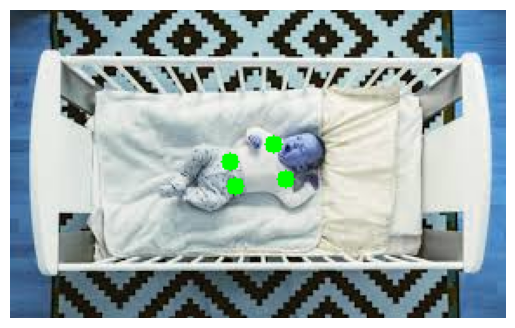

In [30]:
# Khởi tạo MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Đọc ảnh
image_path = cv2.imread("datasets_testing/4.jpg")
rgb_image = cv2.cvtColor(image_path, cv2.COLOR_BGR2RGB)

# Xử lý ảnh và lấy kết quả pose
baby_pose = pose.process(rgb_image)

if baby_pose.pose_landmarks:
    # Lấy tọa độ các điểm quan trọng
    left_shoulder = baby_pose.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = baby_pose.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_hip = baby_pose.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = baby_pose.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
    
    # Chuyển đổi tọa độ từ hệ tỷ lệ chuẩn sang pixel
    left_shoulder_x = int(left_shoulder.x * image_path.shape[1])  # Tọa độ x vai trái
    left_shoulder_y = int(left_shoulder.y * image_path.shape[0])  # Tọa độ y vai trái
    
    right_shoulder_x = int(right_shoulder.x * image_path.shape[1])  # Tọa độ x vai phải
    right_shoulder_y = int(right_shoulder.y * image_path.shape[0])  # Tọa độ y vai phải
    
    left_hip_x = int(left_hip.x * image_path.shape[1])  # Tọa độ x hông trái
    left_hip_y = int(left_hip.y * image_path.shape[0])  # Tọa độ y hông trái
    
    right_hip_x = int(right_hip.x * image_path.shape[1])  # Tọa độ x hông phải
    right_hip_y = int(right_hip.y * image_path.shape[0])  # Tọa độ y hông phải

    # In kết quả tọa độ
    print(f"Tọa độ vai trái (x, y): ({left_shoulder_x}, {left_shoulder_y})")
    print(f"Tọa độ vai phải (x, y): ({right_shoulder_x}, {right_shoulder_y})")
    print(f"Tọa độ hông trái (x, y): ({left_hip_x}, {left_hip_y})")
    print(f"Tọa độ hông phải (x, y): ({right_hip_x}, {right_hip_y})")
    
    # Hiển thị ảnh với các điểm được đánh dấu
    cv2.circle(image_path, (left_shoulder_x, left_shoulder_y), 5, (0, 255, 0), -1)
    cv2.circle(image_path, (right_shoulder_x, right_shoulder_y), 5, (0, 255, 0), -1)
    cv2.circle(image_path, (left_hip_x, left_hip_y), 5, (0, 255, 0), -1)
    cv2.circle(image_path, (right_hip_x, right_hip_y), 5, (0, 255, 0), -1)
    # Tọa độ các điểm của trẻ
    child_coordinates = {
        "left_shoulder": (left_shoulder_x, left_shoulder_y),
        "right_shoulder": (right_shoulder_x, right_shoulder_y),
        "left_hip": (left_hip_x, left_hip_y),
        "right_hip": (right_hip_x, right_hip_y)
    }

    # Hiển thị ảnh bằng Matplotlib
    plt.imshow(image_path)
    plt.axis('off')  # Tắt trục
    plt.show()
else:
    print("Không phát hiện pose landmarks.")


In [31]:
# Giả sử prediction.json() trả về một dictionary
prediction_output = prediction.json()

# Lưu vào file JSON
output_file = "prediction_output.json"
with open(output_file, "w") as f:
    json.dump(prediction_output, f, indent=4)

print(f"Kết quả đã được lưu vào {output_file}")

Kết quả đã được lưu vào prediction_output.json


In [32]:
# Đọc lại file JSON và kiểm tra trạng thái an toàn của trẻ
with open(output_file, "r") as f:
    data = json.load(f)

In [33]:
def draw_crib_and_landmarks(image_path, data, child_coordinates):
    # Đọc ảnh
    image = cv2.imread(image_path)
    
    # Lấy kích thước ảnh
    image_height, image_width, _ = image.shape

    # Tìm bounding box của Crib
    predictions = data['predictions']
    crib_bbox = next((pred for pred in predictions if pred["class"] == "Crib"), None)
    if crib_bbox is None:
        print("Không tìm thấy bounding box của Crib trong ảnh.")
        return

    # Vẽ bounding box của Crib
    crib_x1 = int((crib_bbox["x"] - crib_bbox["width"] / 2))
    crib_y1 = int((crib_bbox["y"] - crib_bbox["height"] / 2))
    crib_x2 = int((crib_bbox["x"] + crib_bbox["width"] / 2))
    crib_y2 = int((crib_bbox["y"] + crib_bbox["height"] / 2))
    cv2.rectangle(image, (crib_x1, crib_y1), (crib_x2, crib_y2), (255, 0, 0), 2)  # Màu xanh dương cho Crib

    # Vẽ các điểm landmarks của trẻ
    for point_name, (x, y) in child_coordinates.items():
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)  # Màu xanh lá cho các điểm pose
        cv2.putText(image, point_name, (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Hiển thị ảnh với Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị đúng màu
    plt.figure(figsize=(10, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Crib Bounding Box và Pose Landmarks của Trẻ")
    plt.show()

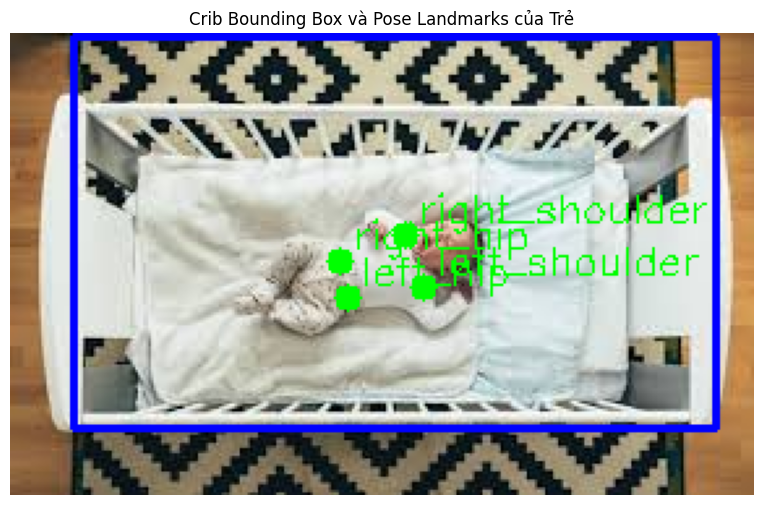

In [34]:
draw_crib_and_landmarks("datasets_testing/4.jpg", data, child_coordinates)

In [35]:
def check_child_outside_crib(data, child_coordinates):
    predictions = data['predictions']
    image_width = int(data['image']['width'])
    image_height = int(data['image']['height'])

    # Tìm bounding box của Crib
    crib_bbox = next((pred for pred in predictions if pred["class"] == "Crib"), None)
    if crib_bbox is None:
        return "Không tìm thấy bounding box của Crib trong ảnh."

    # Chuyển đổi từ x, y, width, height sang [x1, y1, x2, y2]
    def to_corners(bbox):
        x1 = bbox["x"] - bbox["width"] / 2
        y1 = bbox["y"] - bbox["height"] / 2
        x2 = bbox["x"] + bbox["width"] / 2
        y2 = bbox["y"] + bbox["height"] / 2
        return [max(0, x1), max(0, y1), min(image_width, x2), min(image_height, y2)]

    crib_corners = to_corners(crib_bbox)
    x1_crib, y1_crib, x2_crib, y2_crib = crib_corners

    # Kiểm tra từng điểm của trẻ
    for point_name, (x, y) in child_coordinates.items():
        if x < x1_crib or x > x2_crib or y < y1_crib or y > y2_crib:
            return f"Cảnh báo: {point_name} (tọa độ: {x}, {y}) nằm ngoài Crib! Trẻ đang gặp nguy hiểm!"
    return "An toàn: Tất cả các điểm của trẻ nằm trong Crib."

In [36]:
result = check_child_outside_crib(data, child_coordinates)
print(result)

An toàn: Tất cả các điểm của trẻ nằm trong Crib.
